# <center>Practical 06: Robot Control</center>

In [13]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
import time
import scipy.linalg as linalg
import pickle

from Practical06_Support.Robot import *
from Practical06_Support.Helper import *
from Practical06_Support.Renderer import Renderer as PenguinPiRenderer
from Practical06_Support.Renderer1D_Prac import RobotRenderer

**See docstring for functions in support scripts**: If you want to know what a function does, just click somewhere within the parentheses that enclose the arguments and hit SHIFT+TAB. If there's a + button at the top of the popup tooltip, this means the documentation spans a few lines, click it to show the full docstring, then scroll up.

## 1. PID Control - 1D Linear System

Recall our 1D robot 

<img src="Practical06_Support/images/1DRobot.png" width="400" height="400" align="center">

We want to implement a controller that generates the signal $\mathbf{u}_t$ required to bring the robot to a desired state $\mathbf{x}_d$

We first define our robot in State-Space Form:

 $\mathbf{x}_{t+1} = A\mathbf{x}_t + B\mathbf{u}_t$ 
 
 $\mathbf{y}_{t} = C\mathbf{x}_t$, 

where $A$ corresponds to the state matrix, $B$ defines the input or control matrix and $C$ corresponds to the output matrix. Our robot will be represented by the Python class ``Robot1D``

In [14]:
class Robot1D(object):

    """
    A simple implementation of a 1D robot in state-space form
    The constant MAX_CONTROL bounds the magnitude of the control signal that can be applied to the robot 
    """

    MAX_CONTROL = 500
    
    def __init__(self, A=np.eye(2), B=np.array([[0],[0]]), C=np.array([0, 0]), initial_state=np.array([[10],[0]])):
        
        """
        Initialize a new model. 
        :param A: nxn state matrix, where n = state dimensionality
        :param B: nx1 input matrix, where n = state dimensionality
        :param C: 1xn input matrix, where n = state dimensionality
        :param initial_state: 2x1 vector with the initial state of our system
        """
        self.A = A
        self.B = B
        self.C = C
        self.state = initial_state
                
    def drive(self, control_u=10):
        """
        Update the system's state given a new control input
        :param control_u: Control input
        """
        # Make sure control signal is within -MAX_CONTROL < control_u < MAX_CONTROL
        clip_control = np.clip(control_u, -self.MAX_CONTROL, self.MAX_CONTROL)
        state_t1 = self.A @ self.state + self.B * clip_control
        self.state = state_t1
            
    def get_state(self):
        """
        Get the system's current state
        """
        return self.state
    
    def get_output(self):
        """
        Get the system's ouput (position of the robot along the 1D line)
        """
        return np.array(self.C @ self.state)
                
    def get_error(self, desired_x):
        """
        This method measures the error (scalar) between the current robot's state and the desired state
        :param desired_x: Desired state (i.e., position) on the 1D line
        """
        return np.array(desired_x - self.state)

### Define our PID Controller

Let us now define our PID controller. Recall the formulation of a PID controller in the discrete domain:

$\mathbf{u}_t = K_p \mathbf{e}_t + K_i \sum_{k = 0}^t \mathbf{e}_k \Delta t + K_d \frac{\mathbf{e}_t - \mathbf{e}_{t-1}}{\Delta t}$, where

- $K_p, K_i, K_d$ are the proportional, integral and derivative gains
- $\mathbf{e}_t$ is the error at time $t$. In our case $\mathbf{e}_t = \mathbf{x}_d - \mathbf{x}_t$
- $\Delta t$ is the rate at which the PID controller is updated



In [15]:
class PID(object):
    
    """A simple PID controller."""

    def __init__(self, system=None, desired_state=None, K_p=0, 
                 K_i=0, K_d=0, update_rate=0.05):
        
        """
        Initialize a new PID controller.
        :param system: The robot system to controlled
        :param desired_state: The goal state that the PID will try to achieve for the robotic system
        :param K_p: The value for the proportional gain K_p
        :param K_i: The value for the integral gain K_i
        :param K_d: The value for the derivative gain K_d
        :param update_rate: Rate at which the PID controller is updated. 
        """
        self.system = system
        self.set_point = desired_state
        self.K_p = K_p
        self.K_i = K_i
        self.K_d = K_d
        self.update_rate = update_rate
        
        # Last observed error between desired state (self.set_point) and the current state of the system
        self.last_error = self.system.get_error(self.set_point)
        
        # Accumulator for integral term
        self.integral = 0
        
        # Last time the controller was called
        self.last_time = 0
        
        # Last control command provided to the system
        self.last_control = 0
        
    def compute_control(self):
        
        """
        This method computes the next control signal u_t so as to reduce the error
        between the robot's current state and the desired state (self.set_point)
        """
        
        delta_time = self.update_rate
        
        # Compute error
        error_t = self.system.get_error(self.set_point)
        
        # Compute integral and derivative terms
        derivative = (error_t - self.last_error) / delta_time
        self.integral += error_t * delta_time
        
        # Compute new control
        new_control = self.K_p * error_t + self.K_i * self.integral + self.K_d * derivative
        
        # Update self.last_error, self.last_time and self.last_control signal with new values
        self.last_error = error_t
        self.last_time += self.update_rate
        self.last_control = new_control
                
        return new_control

### Test the Controller

Let us now test our controller. We consider the following values in our current test case:
- The robot initial state is $\mathbf{x}_0 = (10, 0)$. The desired states is $\mathbf{x}_d = (50, 0)$
- The PID gains are set to $K_p=0.2, K_i=0, K_d=0.001$
- Our control loop runs for 15 frames (controlled by the variable total_frames) with $dt=0.01$ (controlled by the variable update_rate)

In [26]:
# Define state, input and output matrices
A = np.array([[1, 0], [1, 0]]) # 2D robot but only has control in the x-axis
B = np.array([[0.5],[0]])
C = np.array([1, 0])

# Create a robot and define desired state
initial_state = np.array([[10],[0]])
bot = Robot1D(A=A, B=B, C=C, initial_state=initial_state)
desired_x = np.array([[50],[0]])

# Visualization parameters
u, sim_time, error, robot_state = np.array([[0],[0]]), np.array([0]), bot.get_error(desired_x), bot.get_output()
total_frames = 50
update_rate = 0.01

# Create a PID controller
pid = PID(system=bot, desired_state=desired_x, K_p=0.1, K_i=0, K_d=0.001, update_rate=update_rate)

# This is our control loop. Currently we call our controller for 1 second
for curr_frame in range(1, total_frames, 1):
    
    # Call controller to get new signal u_t
    u_t = pid.compute_control()
    
    # Apply control to robot
    bot.drive(u_t)

    # Save values for plotting
    sim_time = np.hstack( (sim_time, update_rate*int(curr_frame)))
    error = np.hstack((error, bot.get_error(desired_x)))
    u = np.hstack((u, u_t))
    robot_state = np.hstack((robot_state, bot.get_output()))

### Visualise the Resulting Trajectories

Let us now plot the changes observed in error (right-bottom), control signal (right-top), and robot's state (left) 

Box(children=(IntSlider(value=0, description='Frame: ', layout=Layout(flex='3 1 0%', width='auto'), max=49), B…

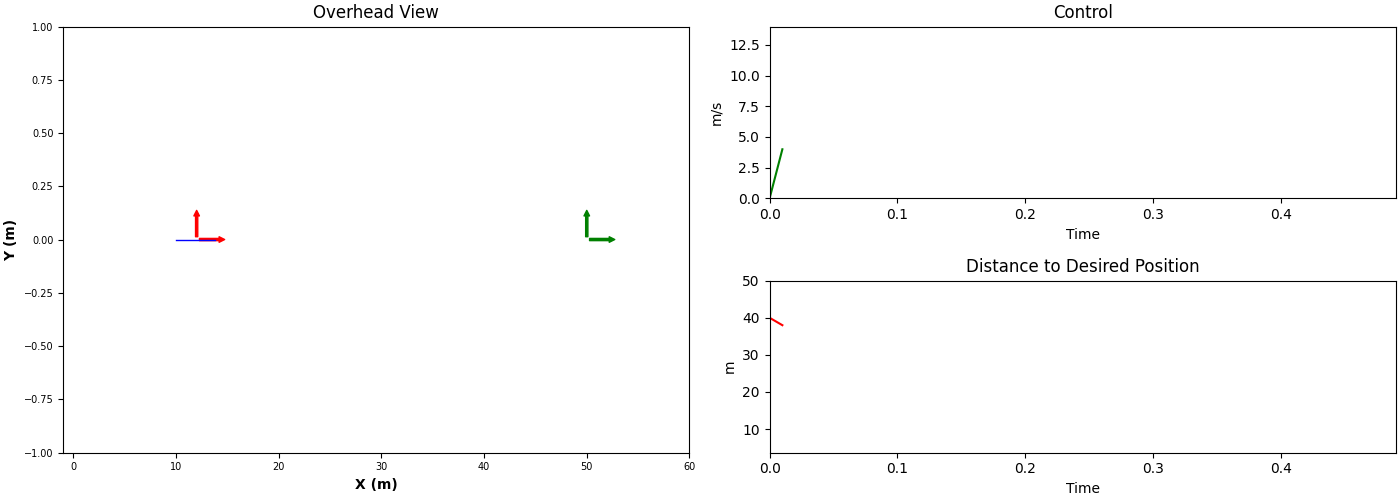

In [27]:
# Define renderer and start animation
rend = RobotRenderer.Instance()
rend.initialize(robot_state, u, error, sim_time, desired_x, dt_render=update_rate)

## 2. PID Control - Differential Drive Vehicle

Recall the kinematic model of our PenguinPi robot:

<img src="Practical06_Support/images/PenguinPi_Model.png" width="400" height="400" align="center">

In this model, the state is defined by a 3D vector ($x, y, \theta)$ and the control input corresponds to the linear and angular velocities $(v, \omega)$.

### Define a Move to Goal Controller

Consider the problem of moving the PenguinPi to a goal point $(x_g, y_g)$. How can we solve this control problem?

Let us define 2 proportional controllers:
- One controller with gain $K_{pw}$ that will turn the robot toward the goal. This controller determines the angular velocity $\omega_k$ according to

$\omega_k = K_{pw} (\theta_g - \theta_r)$,

where $\theta_g$ corresponds to the angle to the goal relative to the heading of the robot and $\theta_r$ is the heading of the robot at time $k$.

- One controller with gain $K_{pv}$ that will keep moving the robot forward until it reaches the goal. This controller determines the linear velocity $v_k$ according to

$v_k = K_{pv}\sqrt{(y_g-y_k)^2+(x_g-x_k)^2}$ 

We have combined these 2 controllers into a single class called ``MoveToGoalController``. Two helper functions ``get_distance_robot_to_goal(.)`` and ``get_angle_robot_to_goal(.)`` have been defined to compute $(\theta_g - \theta_r)$ and $\sqrt{(y_g-y_k)^2+(x_g-x_k)^2}$ respectively.


#### TODO: 
- Compute both $\omega_k$ and $v_k$



In [32]:
class MoveToGoalController(object):
    
    """A simple move to goal proportional controller"""

    def __init__(self, robot=None, K_pw=0, K_pv=0):
        """
        Initialize a new move to goal proportional controller
        :param robot: The robotic system to controlled
        :param K_w: The proportional gain for the angular velocity
        :param K_v: The proportional gain for the linear velocity
        """
        self.robot = robot
        self.K_pw = K_pw
        self.K_pv = K_pv
        
        
    def run(self, goal_position=np.zeros(2), threshold=0.1, delta_time=0.01):
        """
        Run control loop until the robot reaches the goal_position
        :param goal_position: Desired goal position
        :param threshold: Value used to determine whether robot has reached 
                          the goal location
        """
        states = []
        controls = []
        initial_state = self.robot.get_state()
        
        distance_to_goal = get_distance_robot_to_goal(initial_state, goal_position)
        desired_heading = get_angle_robot_to_goal(initial_state, goal_position)
                
        states.append(initial_state)
        
        while distance_to_goal > threshold:
            
            #TODO: Compute control input -----------------------------------------------------
            v_k = self.K_pv * distance_to_goal
            w_k = self.K_pw * desired_heading
            #ENDTODO --------------------------------------------------------------------------
            
            # Apply control to robot
            self.robot.drive(v_k, w_k, delta_time)
            new_state = self.robot.get_state()
            
            # Keep track of variables for plotting
            controls.append([v_k, w_k])
            states.append(new_state)
                        
            # Update distance and desired heading
            distance_to_goal = get_distance_robot_to_goal(new_state, goal_position)
            desired_heading = get_angle_robot_to_goal(new_state, goal_position)
                       
        return states, controls

### Test the Controller

Let us now visualise how our PenguinPi robot moves toward a goal position using the control signals computed by our ``MoveToGoalController``

We consider the following values in our current test case:
- The robot initial state is $\mathbf{x}_0 = (-1.5, -1.5, \frac{\pi}{3})$. The desired states is $\mathbf{x}_d = (1.0, 1.0)$.
- The proportional gains are set to $K_{pw}=5, K_{pv}=2$
- Our control loop runs until $\sqrt{(y_g-y_k)^2+(x_g-x_k)^2} > 0.01$

Box(children=(IntSlider(value=0, description='Frame: ', layout=Layout(flex='3 1 0%', width='auto'), max=119), …

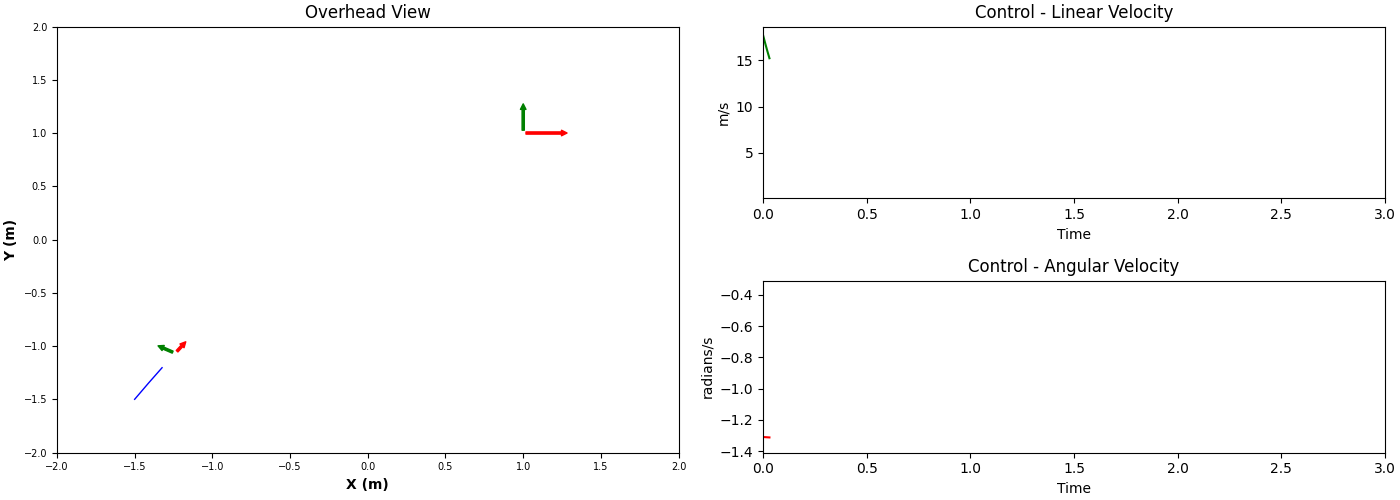

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (3,) and arg 1 with shape (4,).

In [33]:
# Define robot, desired goal and delta time
bot = PenguinPi(init_state=np.array([-1.5, -1.5, np.pi/3]))
desired_goal = np.array([1.0, 1.0]) # target x, target y
delta_t = 0.01

# Instantiate controller and compute sequence of control signals
controller = MoveToGoalController(bot, K_pw=5, K_pv=5)
robot_states, robot_controls = controller.run(goal_position=desired_goal, threshold=0.01, delta_time=delta_t)

# Define variables for animation
array_states = np.array(robot_states)
array_controls = np.array(robot_controls)

# Define renderer and start animation
rend = PenguinPiRenderer.Instance()
rend.initialize(array_states, array_controls, target_pose=desired_goal, dt_data=delta_t)

## 3. LQR - Discrete Time Infinite Horizon

Given a linear system with equations:

$\mathbf{x}_{t+1} = A\mathbf{x}_t + B\mathbf{u}_t$

$\mathbf{y}_{t} = C\mathbf{x}_t$,

where $A$ corresponds to the state matrix, $B$ defines the input or control matrix and $C$ corresponds to the output matrix.

We wan to find $\mathbf{u}$ so as to minimize the cost function

$J = \sum_{t=0}^{\infty} ((\mathbf{x}_t-\mathbf{x}_g)^TQ(\mathbf{x}_t-\mathbf{x}_g) + \mathbf{u}_t^TR\mathbf{u})$,

where Q defines the state cost and R corresponds to the control cost.

To do so, we want to implement a **LQR Infinite Horizon Controller** with gain  
$K = (R+B^TPB)^{-1}(B^TPA)$

**TODO:**
- Complete the definition of the controller's gain K. You can use the function ``linalg.inv(.)`` to compute the inverse of a matrix
- Keep in mind that $P$ is defined by the class attribute ``self.P``

In [46]:
class DiscreteInfiniteLQR(object):
    
    """A simple LQR Infinite Horizon controller."""

    def __init__(self, Q=np.eye(2), R=0.3):
        
        """
        Initialize a new LQR controller.
        :param Q: State cost
        :param R: Control cost
        """
        
        self.Q = Q
        self.R = R
        
        # Controller gain to be defined once LQR function is solved
        self.K = np.zeros(2)
        self.P = np.eye(2)
                
    def solve(self, system):
        """
        Compute controller gain for a given system
        :param system: Linear system for which a control law needs to be
                       computed
        """
        A = system.A
        B = system.B
        
        # Solve Riccati Equation
        self.P = linalg.solve_discrete_are(A, B, self.Q, self.R)
                
        #TODO: Compute the controller's gain ----------------------------------------------
        self.K = np.zeros([1,2])
        self.K = linalg.inv(self.R + B.T @ self.P @ B) @ (B.T @ self.P @ A)
        #ENDTODO --------------------------------------------------------------------------
        
    def get_gain(self):
        """
        Get access to controller gain
        """
        return self.K

### Test the Controller

Let us now take a look at the state and control trajectories that can obtained using our LQR implementation. Keep in mind that the optimal controller is defined as

$\mathbf{u_t} = -K(\mathbf{x_t} - \mathbf{x_g})$,

where $\mathbf{x_g}$ corresponds to the desired state.

We consider the same test case used with our PID controller:
- The robot initial state is $\mathbf{x}_0 = (10, 0)$. The desired states is $\mathbf{x}_d = (50, 0)$
- Our control loop for 25 time steps with the update rate defined by the variable update_rate

In [49]:
# Create an instance of our 1D robot system
A = np.array([[1, 0], [1, 0]])
B = np.array([[0.5],[0]])
C = np.array([1, 0])

bot = Robot1D(A=A, B=B, C=C, initial_state=np.array([[10], [0]]))

# Define the state and control costs
Q = np.array([[5,0],[0,0]])
R = 30

# Create an instace of our controller and solve the LQR problem
lqr = DiscreteInfiniteLQR(Q=Q, R=R)
lqr.solve(bot)

# Define desired state
desired_x = np.array([[50],[0]])

# Visualization parameters
u_list, sim_time = np.array([[0]]), np.array([0])

error = bot.get_error(desired_x)
y_list = bot.get_output()
update_rate = 0.01
total_frames = 25

# This is our control loop. 
for curr_frame in range(1, total_frames, 1):
    
    # Get current state of the system
    x_t = bot.get_state()
    # Get output 
    y_t = bot.get_output()
    
    # Determine and apply control
    u_t = np.array(-lqr.K @ (x_t - desired_x))
    bot.drive(u_t)
    
    # Keep track of variable for plotting
    sim_time = np.hstack( (sim_time, update_rate*curr_frame))
    u_list =np.hstack((u_list, u_t))
    y_list = np.hstack((y_list,y_t)) 
    error = np.hstack((error, bot.get_error(desired_x)))

### Visualise the Resulting Trajectories

Let us now plot the changes observed in error (right-bottom), control signal (right-top), and robot's state (left) 

Box(children=(IntSlider(value=0, description='Frame: ', layout=Layout(flex='3 1 0%', width='auto'), max=24), B…

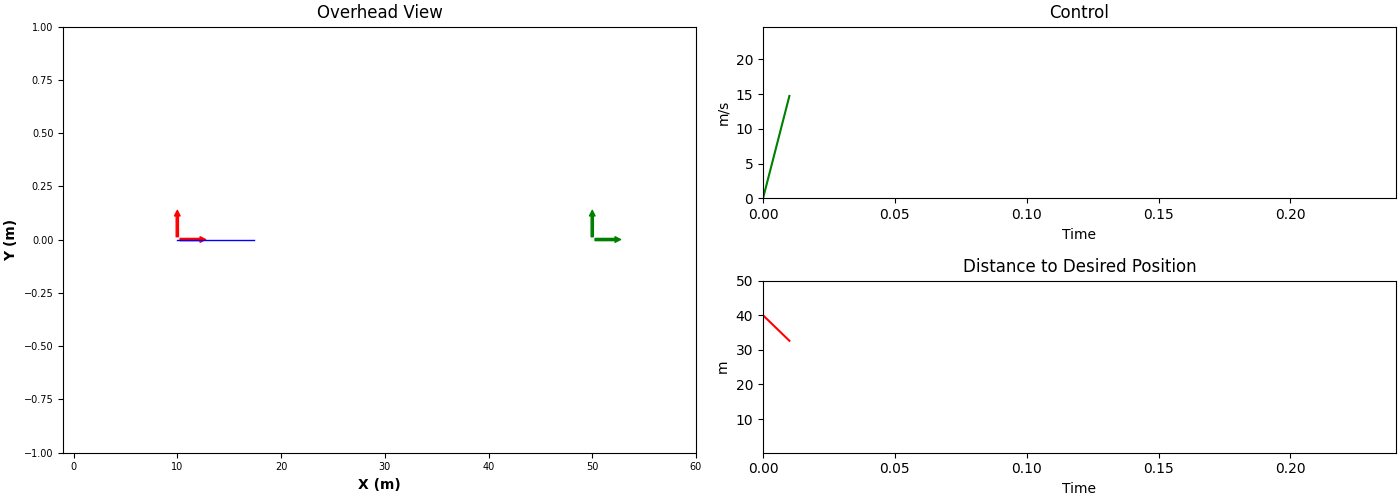

In [50]:
# Define renderer and start animation
rend = RobotRenderer.Instance()
rend.initialize(y_list, u_list, error, sim_time, desired_x, dt_render=update_rate)